## Install dependencies

In [ ]:
!pip install tweepy
!pip install pymongo
!pip install vaderSentiment
!pip install emoji

## Import some needed scripts

In [17]:
from dataset import getFeaturesFromDBData, getUserFeaturesFromTweets, Database
from pprint import pprint
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from api import API
import ml, pandas as pd, numpy as np

## Define some constants needed

In [2]:
MONGO_DB_URI = "mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&directConnection=true&ssl=false"
USER_DATASET_FILE = "users_dataset.csv"

## Initialize tweeter API

In [3]:
api = API();

## Gather data using twitter API and populate MongoDB

We gather the data in a way to try to maintain a 50-50% of bots and humans

In [ ]:
api.getDataFromTweeterInDB(MONGO_DB_URI,USER_DATASET_FILE)          #Gather tweet data using tweeter API and store in MongoDB

## Create our features dataset using the data we have in the database

In [ ]:
dataset = getFeaturesFromDBData(MONGO_DB_URI)                   #Load data from MongoDB, calculate features and return feature dataset
dataset.fillna(value=0)                                         #Fill all null values with zero
dataset.to_csv("dataset.csv")                                   #Save dataset to CSV
dataset["label"] = dataset["label"].map({"HUMAN": 0, "BOT": 1}) #Map BOT label to 1 and Human label to 0
pprint('Done!')

In [7]:
dataset.describe()

,days_since_creation,has_bot_word_in_descriptionbot_word_in_description,has_bot_word_in_descriptionnot_bot_word_in_description,has_bot_word_in_namebot_word_in_name,has_bot_word_in_namenot_bot_word_in_name,has_bot_word_in_screen_namebot_word_in_screen_name,has_bot_word_in_screen_namenot_bot_word_in_screen_name,numbers_in_name,numbers_in_screen_name,user_description_length,...,statistics_of_their_retweets_median,statistics_of_their_retweets_std,statistics_of_their_retweets_skew,statistics_of_their_retweets_kurtosis,statistics_of_their_retweets_entropy,tweet_retweet_ratio,unique_mentions_rate,get_average_age_difference_in_retweets,number_of_accounts_retweeted,label
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.0,2400.000000,2400.000000
mean,3930.075417,0.003750,0.996250,0.000833,0.999167,0.000833,0.999167,0.015417,0.172083,67.414583,...,1678.743958,7879.601828,1.320489,6.707483,0.799205,86.955118,0.131320,0.0,14.129583,0.486667
std,668.729890,0.061135,0.061135,0.028861,0.028861,0.028861,0.028861,0.147834,0.389488,50.462250,...,16748.829655,36217.748416,2.258523,18.838648,1.229459,84.321796,0.168705,0.0,27.506039,0.499926
min,2380.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.747108,-3.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,3367.750000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,21.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.122940,0.000000,0.0,0.000000,0.000000
50%,3980.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,63.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,0.060000,0.0,0.000000,0.000000
75%,4505.250000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,110.000000,...,57.000000,1765.208681,2.158710,3.654116,1.403695,199.000000,0.238000,0.0,12.000000,1.000000
max,5614.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,3.000000,160.000000,...,514016.000000,869197.861603,13.695076,186.032120,5.240392,200.000000,1.525000,0.0,165.000000,1.000000


## Train supervised models and get metrics

In [8]:
results = ml.trainSupervisedModels(dataset)
for result in results:
    print('Model : ' + result['name'])
    pprint(result['metrics'])
    print('-----')

Model : RF
{'accuracy': 0.8533333333333333,
 'f1_weighted': 0.8534078743016025,
 'precision_weighted': 0.8544268301445461,
 'recall_weighted': 0.8533333333333333,
 'roc_auc': 0.9176020837554141}
-----
Model : KNN
{'accuracy': 0.8091666666666667,
 'f1_weighted': 0.8085444595754516,
 'precision_weighted': 0.813332143628309,
 'recall_weighted': 0.8091666666666667,
 'roc_auc': 0.8717521719799113}
-----
Model : SVM
{'accuracy': 0.8295833333333335,
 'f1_weighted': 0.8296155693848425,
 'precision_weighted': 0.8301823742189297,
 'recall_weighted': 0.8295833333333335,
 'roc_auc': 0.8873764775093702}
-----
Model : GNB
{'accuracy': 0.7429166666666667,
 'f1_weighted': 0.7199030935622311,
 'precision_weighted': 0.7810597775174531,
 'recall_weighted': 0.7429166666666667,
 'roc_auc': 0.8519869845895531}
-----


## Compare supervised algorithms

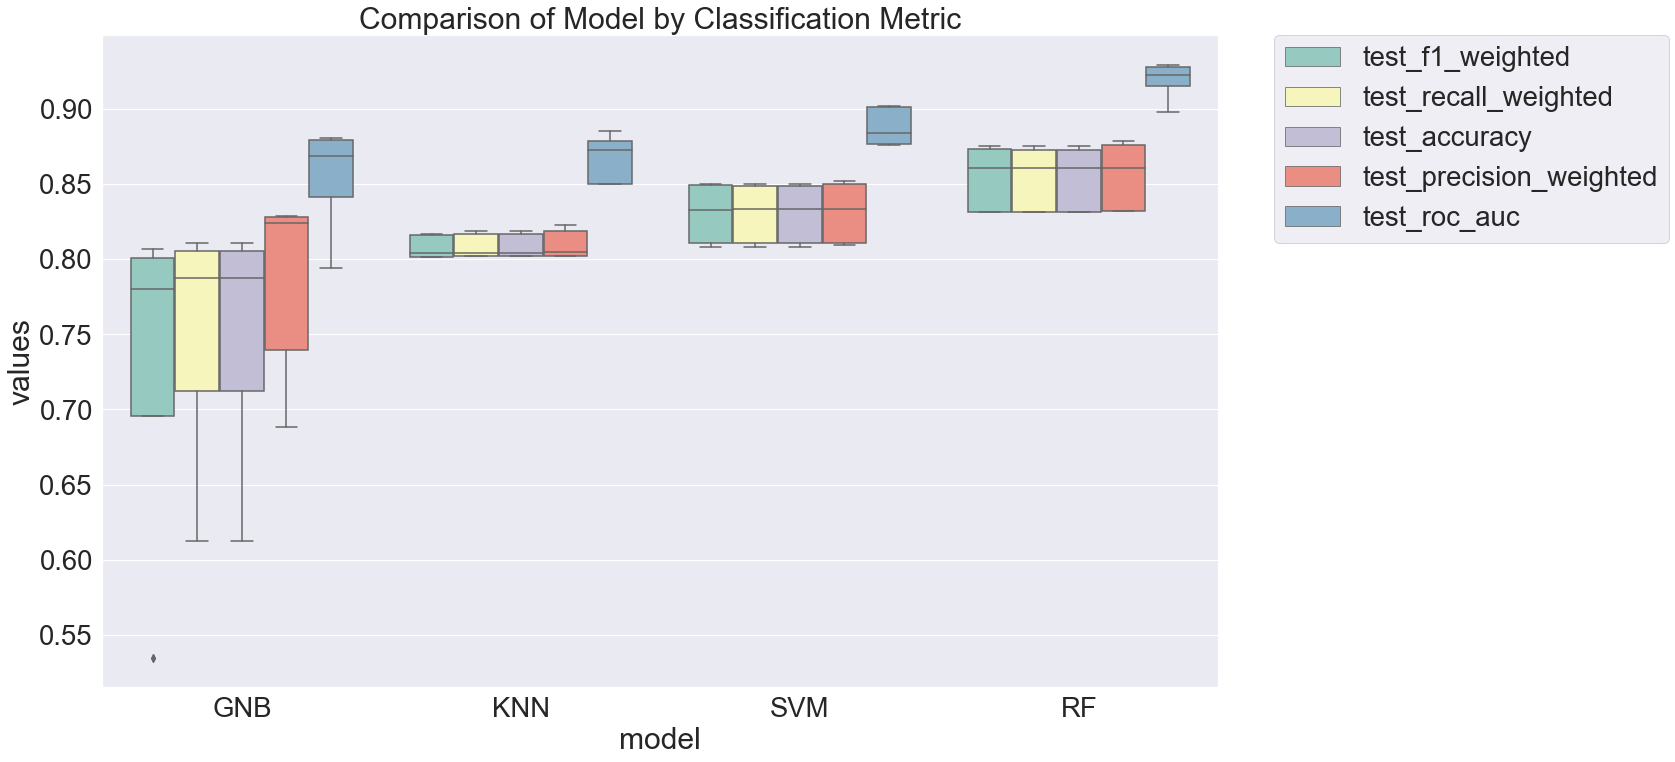

In [9]:
ml.supervisedModelComparison(results)

## Apply the models to some real accounts

### Gather timeline of some real users

In [10]:
accounts = {
    "234343780":            "@Aristoteleio",
    "48008938":             "@ylecun",
    "249130209":            "@nportokaloglou",
    "1348351605654106118":  "@greeceinfigures",
    "86391789":             "@big_ben_clock",
    "70340615":             "@adonisgeorgiadi",
    "289527193":            "@kostasvaxevanis",
    "1005766052607938560":  "@vanitysthasmin",
    "62213337":             "@akurkov",
    "1495855082734297095":  "@ve10ve_ghost",
    "1976335622":           "@adarshburman2",
    "1066275282653536256":  "@bassaces1"
}
tweets = api.getUserListTimelineFromTwitter([
    userID for userID in accounts
    ])

### Get the features of the gathered users

In [11]:
for result in results:
    print("Model : " + result["name"])
    for userID in tweets:
        tweet_list = []
        for t in tweets[userID]:
            tweet_list.append(t._json)
        featuresList, _ = getUserFeaturesFromTweets(tweet_list,userID)
        label = result["model"].predict(featuresList.values);
        label = 'BOT' if label == 1 else 'HUMAN'
        print(f"User : '{accounts[userID]}' -> '{label}'")
    print("--------------------------------")

Model : RF
User : '@Aristoteleio' -> 'BOT'
User : '@ylecun' -> 'BOT'
User : '@nportokaloglou' -> 'BOT'
User : '@greeceinfigures' -> 'BOT'
User : '@big_ben_clock' -> 'BOT'
User : '@adonisgeorgiadi' -> 'BOT'
User : '@kostasvaxevanis' -> 'BOT'
User : '@vanitysthasmin' -> 'BOT'
User : '@akurkov' -> 'HUMAN'
User : '@ve10ve_ghost' -> 'HUMAN'
User : '@adarshburman2' -> 'HUMAN'
User : '@bassaces1' -> 'HUMAN'
--------------------------------
Model : KNN
User : '@Aristoteleio' -> 'BOT'
User : '@ylecun' -> 'HUMAN'
User : '@nportokaloglou' -> 'BOT'
User : '@greeceinfigures' -> 'BOT'
User : '@big_ben_clock' -> 'HUMAN'
User : '@adonisgeorgiadi' -> 'BOT'
User : '@kostasvaxevanis' -> 'HUMAN'
User : '@vanitysthasmin' -> 'BOT'
User : '@akurkov' -> 'BOT'
User : '@ve10ve_ghost' -> 'HUMAN'
User : '@adarshburman2' -> 'HUMAN'
User : '@bassaces1' -> 'HUMAN'
--------------------------------
Model : SVM
User : '@Aristoteleio' -> 'BOT'
User : '@ylecun' -> 'BOT'
User : '@nportokaloglou' -> 'BOT'
User : '@greecein

## Unsupervised Algorithms

### Find the appropriate cluster number

### Scale data

In [12]:
df_std = preprocessing.scale(dataset)
df_std = pd.DataFrame(df_std)

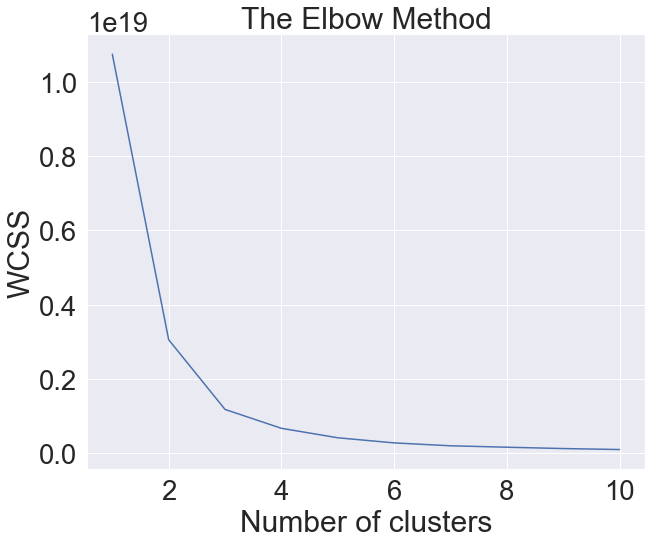

In [13]:
plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(dataset)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Train K-Means model

In [14]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(dataset)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
dataset['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(dataset.groupby('cluster').mean(),1))
kmeans_mean_cluster

,days_since_creation,has_bot_word_in_descriptionbot_word_in_description,has_bot_word_in_descriptionnot_bot_word_in_description,has_bot_word_in_namebot_word_in_name,has_bot_word_in_namenot_bot_word_in_name,has_bot_word_in_screen_namebot_word_in_screen_name,has_bot_word_in_screen_namenot_bot_word_in_screen_name,numbers_in_name,numbers_in_screen_name,user_description_length,...,statistics_of_their_retweets_median,statistics_of_their_retweets_std,statistics_of_their_retweets_skew,statistics_of_their_retweets_kurtosis,statistics_of_their_retweets_entropy,tweet_retweet_ratio,unique_mentions_rate,get_average_age_difference_in_retweets,number_of_accounts_retweeted,label
cluster,,,,,,,,,,,,,,,,,,,,,
1,3769.8,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.2,69.5,...,930.9,4058.1,1.1,5.9,0.7,96.5,0.1,0.0,12.7,0.4
2,4395.3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.2,81.9,...,906.6,9449.2,1.0,4.6,0.5,115.7,0.1,0.0,9.2,0.7
3,4201.7,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.2,48.1,...,2570.6,25567.6,3.2,17.1,1.4,20.9,0.2,0.0,25.5,0.3
4,4058.3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.2,55.2,...,5197.2,16441.0,1.9,9.4,1.3,46.9,0.2,0.0,22.3,0.5
5,4340.2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.2,38.4,...,2876.6,19548.6,2.0,7.7,0.8,27.4,0.2,0.0,12.7,0.8


### K-Means Clustering based on Activity

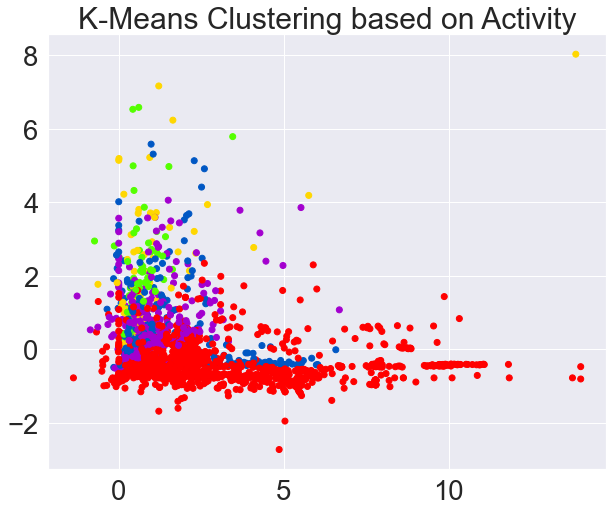

In [15]:
plt.figure(figsize=(10, 8))
plt.scatter(dataset.iloc[:,21], df_std.iloc[:,31],c=cluster, cmap='prism')  #plot points with cluster dependent colors
plt.title('K-Means Clustering based on Activity')
plt.show()

### Hierarchical clustering for the same dataset

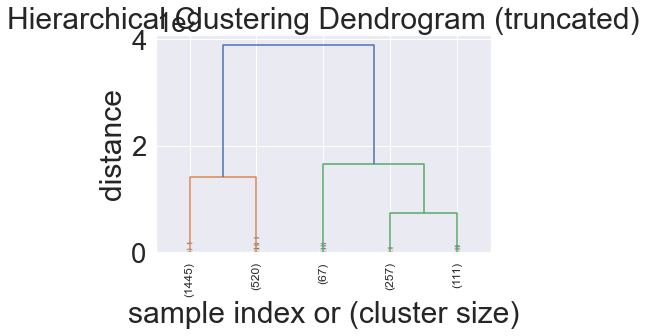

In [18]:
# creating a dataset for hierarchical clustering
dataset2_standardized = dataset.copy()
# some setting for this notebook to actually show the graphs inline
# you probably won't need this
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
#creating the linkage matrix
H_cluster = linkage(dataset2_standardized,'ward')
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    H_cluster,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=5,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

### Hierarchical Clutering based on Activity

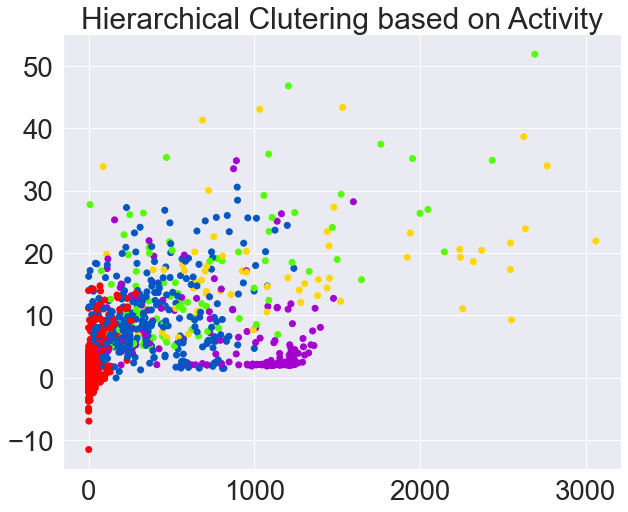

In [19]:
# Assigning the clusters and plotting the observations as per hierarchical clustering
k=5
cluster_2 = fcluster(H_cluster, k, criterion='maxclust')
cluster_2[0:30:,]
plt.figure(figsize=(10, 8))
plt.scatter(dataset2_standardized.iloc[:,25], dataset2_standardized.iloc[:,31],c=cluster_2, cmap='prism')  # plot points with cluster dependent colors
plt.title('Hierarchical Clutering based on Activity')
plt.show()